<a href="https://colab.research.google.com/github/ting486/Consumer-Reviews-And-Purchasing-Decisions/blob/main/amazon_video_games_25GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Consumer Reviews Data Analysis

## Notebook Setup

In [163]:
# check available RAM
!free -h

              total        used        free      shared  buff/cache   available
Mem:            25G         10G         13G        1.2M        1.5G         17G
Swap:            0B          0B          0B


In [2]:
# data source: http://deepyeti.ucsd.edu/jianmo/amazon/index.html
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download(['vader_lexicon','stopwords'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Product Data

### Data Initialization

In [4]:
# get products data
dfProd = pd.read_json('gdrive/MyDrive/amazon_data/meta_Video_Games.json', lines=True)

In [5]:
print(dfProd.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [6]:
print(dfProd.head())

                                            category tech1  \
0                           [Video Games, PC, Games]         
1  [Video Games, Xbox 360, Games, </span></span><...         
2  [Video Games, Retro Gaming & Microconsoles, Su...         
3  [Video Games, Xbox 360, Accessories, Controlle...         
4  [Video Games, PC, Games, </span></span></span>...         

                                         description fit  \
0                                                 []       
1                                [Brand new sealed!]       
2                                                 []       
3  [MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...       
4  [Phonics Alive! 3, The Speller teaches student...       

                                               title      also_buy tech2  \
0                         Reversi Sensory Challenger            []         
1  Medal of Honor: Warfighter - Includes Battlefi...  [B00PADROYW]         
2  street fighter 2 II turbo super nin

### Data Cleaning

In [7]:
# drop duplicates
dfProdDup = dfProd.loc[dfProd.duplicated(['asin'])]
dfProdDup = dfProd.loc[dfProd['asin'].isin(list(dfProdDup['asin']))]
dfProdDup = dfProdDup.sort_values(by='asin')

dfProd = dfProd.drop_duplicates(['asin'], ignore_index=True)

#### Rank

In [8]:
dfProd['rank'] = dfProd['rank'].apply(lambda x: [x] if len(x) > 4 else x)

def rank_mod(s):
  res = [ss.replace(',', '').replace('&amp;', '&').replace('\n', '').replace('\t', '').replace('\\', '').replace('#',
             '').replace('&gt;', '>').lstrip('>').rstrip(' (') for ss in s]
  res = [re.sub(" ([\(\[]).*?([\)\]])", "", r) for r in res]
  res = sorted(res, key=lambda x: x.count('>'))

  res = [item.split(' in ', 1) for item in res]
  res = [item for l in res for item in l]

  return res

dfProd['rank'] = dfProd['rank'].apply(lambda x: rank_mod(x))

In [9]:
dfProdRank = pd.DataFrame(dfProd['rank'].to_list(), columns=['rank1', 'category1', 'rank2', 'category2',
                                                              'rank3', 'category3', 'rank4', 'category4'])

In [10]:
dfProdRank = dfProdRank.merge(dfProd, left_index=True, right_index=True)
dfProdRank = dfProdRank[['rank1', 'category1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                         'asin', 'title', 'main_cat', 'category']]

In [11]:
dfProdRank = dfProdRank.loc[dfProdRank['category1'].notna()]
dfProdRank['category1'] = dfProdRank.category1.str.replace(r'^Video Games.*', 'Video Games', regex=True)
dfProdRank['category'] = [','.join(map(str, l)) for l in dfProdRank['category']]

# only use the products that have a BSR in category Video Games, for easier comparison amongst video game products
dfProdRank = dfProdRank.loc[dfProdRank['category1'] == 'Video Games']

# remove irrelevant products like accessories
dfProdRank = dfProdRank.loc[(dfProdRank['main_cat'].isin(['Video Games', 'Sports & Outdoors', ''])) & 
                              (~dfProdRank['category'].str.contains('accessories', case=False))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# merge rank info into original product data
dfProd = dfProd.merge(dfProdRank, how='inner', on='asin', suffixes=('', '_y'))

In [13]:
dfProd = dfProd.astype({'rank1': 'float64', 'rank2': 'float64', 'rank3': 'float64', 'rank4': 'float64'})
dfProd = dfProd.astype({'rank1': 'Int64', 'rank2': 'Int64', 'rank3': 'Int64', 'rank4': 'Int64'})

#### Brand

In [14]:
dfProd['brand'] = dfProd['brand'].str.replace('by\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('\n', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.replace('by ', '', regex=True)
dfProd['brand'] = dfProd['brand'].str.lstrip()

In [15]:
dfProd = dfProd.replace({'EA': 'Electronic Arts', 'EA Games': 'Electronic Arts', 'At Electronic Arts': 'Electronic Arts',
                         'Electronic Arts Sports': 'EA Sports', 'Electronic Arts, Inc.': 'Electronic Arts',
                         'Electronic Arts Inc.': 'Electronic Arts', 'Electronic Arts 1001573': 'EA Sports',
                         'EA Active': 'EA Sports', 'Electronic Arts UK IMPORT': 'EA Sports'})
dfProd = dfProd.replace({'HPS Simulation': 'HPS Simulations'})
dfProd = dfProd.replace({'PS1': 'Playstation', 'PS2': 'Playstation', 'PS3': 'Playstation', 'PS4': 'Playstation'})
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 2.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS 3.*$)', 'Playstation', regex=True)
dfProd['brand'] = dfProd.brand.str.replace(r'(^.*PS4.*$)', 'Playstation', regex=True)

# dfProd = dfProd.replace({'': None, 'Unknown': None})

In [ ]:
# dfProd[['brand', 'title']].loc[dfProd['brand'].str.contains('xbox', case=False)].sort_values(by='brand')

In [9]:
# dfProdBrand = dfProd['brand'].value_counts(dropna=False).reset_index()
# dfProdBrand

#### Others

In [180]:
# clean date
# dfProd['date'] = dfProd['date'].replace({'.*div.*': np.nan, '83001177': np.nan, 'Creazydog': np.nan}, regex=True)
# dfProd['date'] = pd.to_datetime(dfProd['date'])

In [16]:
# convert price to float dtype
def convert_float(x):
    try:
        return float(x)
    except:
        return np.nan
dfProd['price'] = dfProd['price'].str.replace('$', '', regex=True)
dfProd['price'] = dfProd['price'].str.replace(',', '', regex=True)
dfProd['price'] = dfProd['price'].replace({'': np.nan})
dfProd['price'] = dfProd['price'].apply(lambda p: convert_float(p))

In [17]:
dfProd.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40943 entries, 0 to 40942
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         40943 non-null  object 
 1   tech1            40943 non-null  object 
 2   description      40943 non-null  object 
 3   fit              40943 non-null  object 
 4   title            40943 non-null  object 
 5   also_buy         40943 non-null  object 
 6   tech2            40943 non-null  object 
 7   brand            40943 non-null  object 
 8   feature          40943 non-null  object 
 9   rank             40943 non-null  object 
 10  also_view        40943 non-null  object 
 11  main_cat         40943 non-null  object 
 12  similar_item     40943 non-null  object 
 13  date             40943 non-null  object 
 14  price            6856 non-null   float64
 15  asin             40943 non-null  object 
 16  imageURL         40943 non-null  object 
 17  imageURLHigh

### Data Manipulation

In [18]:
# count number of images & high resolution images
dfProd['numImages'] = dfProd['imageURL'].str.len()
dfProd['numHighResImages'] = dfProd['imageURLHighRes'].str.len()

In [19]:
dfProd['feature'] = [','.join(map(str, l)) for l in dfProd['feature']]

In [20]:
dfProd['description'] = [','.join(map(str, l)) for l in dfProd['description']]

In [21]:
dfProdDetails = dfProd.loc[(~dfProd['details'].isna()) & (dfProd['details'].str.len() > 0)]
dfProdDetails = dfProdDetails[['details']]

dfProdDetails['details'] = [list(d.keys()) for d in dfProdDetails['details']]
dfProdDetails['details'] = [','.join(map(str, l)) for l in dfProdDetails['details']]
dfProdDetails['details'] = dfProdDetails['details'].replace({':': '', '\n': ''}, regex=True)
dfProdDetails['details'] = dfProdDetails['details'].replace({' ': ''}, regex=True)

dfProd = dfProd.merge(dfProdDetails, how='left', left_index=True, right_index=True)

In [22]:
dfProd['numDetails'] = dfProd['details_x'].str.len()
dfProd['numDetails'] = dfProd['numDetails'].fillna(0)

In [23]:
# final touch-up
dfProd = dfProd.astype({'numImages': np.uint8, 'numHighResImages': np.uint8, 'numDetails': np.uint8})
dfProd = dfProd[['asin', 'title', 'brand', 'category_y', 'price', #'category', 
                 'rank1', 'rank2', 'category2', 'rank3', 'category3', 'rank4', 'category4',
                 'numImages', 'numHighResImages', 'numDetails',
                 'main_cat', 'details_y', 'feature'#, 'also_buy', 'also_view', 'similar_item' #'description'
                 ]]
dfProd = dfProd.rename(columns={'category_y': 'categories', 'details_y': 'details', 'rank1': 'rankVideoGames'})

In [24]:
dfProd.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40943 entries, 0 to 40942
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   asin              40943 non-null  object 
 1   title             40943 non-null  object 
 2   brand             40943 non-null  object 
 3   categories        40943 non-null  object 
 4   price             6856 non-null   float64
 5   rankVideoGames    40943 non-null  Int64  
 6   rank2             38639 non-null  Int64  
 7   category2         38639 non-null  object 
 8   rank3             8388 non-null   Int64  
 9   category3         8388 non-null   object 
 10  rank4             5375 non-null   Int64  
 11  category4         5375 non-null   object 
 12  numImages         40943 non-null  uint8  
 13  numHighResImages  40943 non-null  uint8  
 14  numDetails        40943 non-null  uint8  
 15  main_cat          40943 non-null  object 
 16  details           63 non-null     object

In [25]:
dfProd.describe(include='all')

,asin,title,brand,categories,price,rankVideoGames,rank2,category2,rank3,category3,rank4,category4,numImages,numHighResImages,numDetails,main_cat,details,feature
count,40943,40943,40943,40943,6856.000000,40943.000000,38639.000000,38639,8.388000e+03,8388,5.375000e+03,5375,40943.000000,40943.000000,40943.000000,40943,63,40943
unique,40943,38860,3742,8069,NaN,NaN,NaN,168,NaN,150,NaN,79,NaN,NaN,NaN,3,18,23917
top,0078764343,NBA 2K15 - PlayStation 4,Electronic Arts,"Video Games,PC,Games,</span></span></span>",NaN,NaN,NaN,Video Games > PC Games > PC Games,NaN,Video Games > PC Games > Digital Games & DLC,NaN,Video Games > PC Games > PC Games,NaN,NaN,NaN,Video Games,"ProductDimensions,ShippingWeight,DomesticShipp...",
freq,1,9,2422,6704,NaN,NaN,NaN,7933,NaN,3620,NaN,3588,NaN,NaN,NaN,40897,12,11541
mean,NaN,NaN,NaN,NaN,51.385702,65891.790538,4559.875385,NaN,3.996635e+03,NaN,7.479761e+03,NaN,3.020492,3.020492,0.007889,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,81.081829,49863.193910,10739.535219,NaN,2.546347e+04,NaN,2.548324e+04,NaN,3.076086,3.076086,0.209820,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.010000,2.000000,1.000000,NaN,1.000000e+00,NaN,1.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,13.987500,26592.500000,416.000000,NaN,5.000000e+02,NaN,6.965000e+02,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,27.285000,54945.000000,1285.000000,NaN,1.868500e+03,NaN,4.586000e+03,NaN,2.000000,2.000000,0.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,55.802500,93294.000000,5410.000000,NaN,4.353250e+03,NaN,1.083100e+04,NaN,6.000000,6.000000,0.000000,NaN,NaN,NaN


### Plots

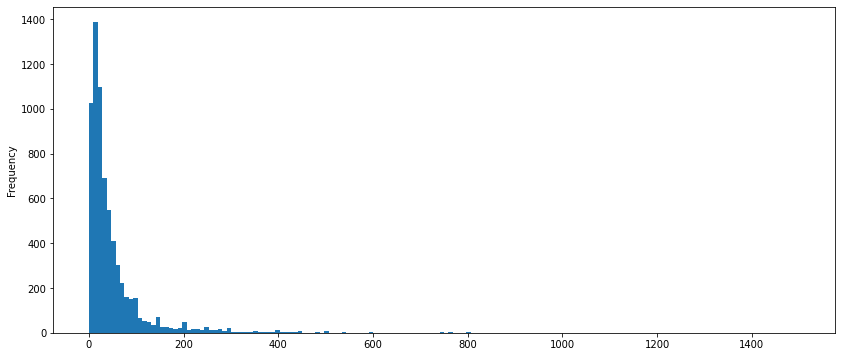

In [26]:
dfProd['price'].plot.hist(bins=160, figsize=(14,6))

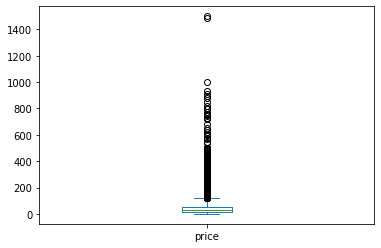

In [27]:
dfProd['price'].plot.box()

## Reviews Data

### Initial Data

In [28]:
# get reviews data
dfReviews = pd.read_json("gdrive/MyDrive/amazon_data/Video_Games.json", lines=True)

In [29]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         2565349 non-null  int64 
 1   verified        2565349 non-null  bool  
 2   reviewTime      2565349 non-null  object
 3   reviewerID      2565349 non-null  object
 4   asin            2565349 non-null  object
 5   reviewerName    2565096 non-null  object
 6   reviewText      2563634 non-null  object
 7   summary         2564538 non-null  object
 8   unixReviewTime  2565349 non-null  int64 
 9   vote            442716 non-null   object
 10  style           1319972 non-null  object
 11  image           28305 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 217.7+ MB
None


In [30]:
print(dfReviews.describe())

            overall  unixReviewTime
count  2.565349e+06    2.565349e+06
mean   4.022095e+00    1.388666e+09
std    1.405936e+00    1.159381e+08
min    1.000000e+00    8.789472e+08
25%    3.000000e+00    1.356653e+09
50%    5.000000e+00    1.421885e+09
75%    5.000000e+00    1.465430e+09
max    5.000000e+00    1.538438e+09


In [31]:
print(dfReviews.head())

   overall  verified   reviewTime      reviewerID        asin  \
0        1      True   06 9, 2014  A21ROB4YDOZA5P  0439381673   
1        3      True  05 10, 2014  A3TNZ2Q5E7HTHD  0439381673   
2        4      True   02 7, 2014  A1OKRM3QFEATQO  0439381673   
3        1      True   02 7, 2014  A2XO1JFCNEYV3T  0439381673   
4        4      True  01 16, 2014  A19WLPIRHD15TH  0439381673   

       reviewerName                                         reviewText  \
0     Mary M. Clark  I used to play this game years ago and loved i...   
1         Sarabatya  The game itself worked great but the story lin...   
2   Amazon Customer  I had to learn the hard way after ordering thi...   
3  ColoradoPartyof5  The product description should state this clea...   
4    Karen Robinson  I would recommend this learning game for anyon...   

                                             summary  unixReviewTime vote  \
0                                  Did not like this      1402272000  NaN   
1         

### Data Cleaning

In [32]:
dfReviews['reviewTime'] = pd.to_datetime(dfReviews['reviewTime'])

In [33]:
# convert vote to int
dfReviews['vote'] = dfReviews['vote'].replace({',': ''}, regex=True)
dfReviews['vote'] = dfReviews['vote'].fillna(0)
dfReviews['vote'] = dfReviews['vote'].astype('float32').astype('Int32')

In [34]:
# rename overall to rating as it makes more sense and change data type to uint8 to save memory
dfReviews = dfReviews.astype({'overall': np.uint8})
dfReviews = dfReviews.rename(columns={'overall': 'rating'})

In [35]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   rating          2565349 non-null  uint8         
 1   verified        2565349 non-null  bool          
 2   reviewTime      2565349 non-null  datetime64[ns]
 3   reviewerID      2565349 non-null  object        
 4   asin            2565349 non-null  object        
 5   reviewerName    2565096 non-null  object        
 6   reviewText      2563634 non-null  object        
 7   summary         2564538 non-null  object        
 8   unixReviewTime  2565349 non-null  int64         
 9   vote            2565349 non-null  Int32         
 10  style           1319972 non-null  object        
 11  image           28305 non-null    object        
dtypes: Int32(1), bool(1), datetime64[ns](1), int64(1), object(7), uint8(1)
memory usage: 193.3+ MB
None


In [36]:
print(dfReviews.describe())

             rating  unixReviewTime          vote
count  2.565349e+06    2.565349e+06  2.565349e+06
mean   4.022095e+00    1.388666e+09  1.449120e+00
std    1.405936e+00    1.159381e+08  1.289650e+01
min    1.000000e+00    8.789472e+08  0.000000e+00
25%    3.000000e+00    1.356653e+09  0.000000e+00
50%    5.000000e+00    1.421885e+09  0.000000e+00
75%    5.000000e+00    1.465430e+09  0.000000e+00
max    5.000000e+00    1.538438e+09  5.154000e+03


### Data Manipulation

#### Time

In [37]:
# separate reviewTime by every 90 days to illustrate review recentness
dfReviews['timeDiff'] = ((dfReviews['reviewTime'].max() + datetime.timedelta(days=1)) - dfReviews['reviewTime']).dt.days
dfReviews['recentness'] = (dfReviews['timeDiff'] / 90).astype(np.uint8) # 90 days = 3 months

#### Style

In [38]:
# get style keys
dfReviewsStyle = dfReviews.loc[(~dfReviews['style'].isna())]

dfReviewsStyle['styleStr'] = [list(d.keys()) for d in dfReviewsStyle['style']]
dfReviewsStyle['styleStr'] = [','.join(map(str, l)) for l in dfReviewsStyle['styleStr']]
dfReviewsStyle['styleStr'] = dfReviewsStyle['styleStr'].replace({':': ''}, regex=True)
dfReviewsStyle = dfReviewsStyle[['styleStr']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [39]:
# merge with dfReviews
dfReviews = dfReviews.merge(dfReviewsStyle, how='left', left_index=True, right_index=True)
dfReviews['styleStr'] = dfReviews['styleStr'].fillna('')

In [40]:
# count number of styles
dfReviews['numStyles'] = dfReviews['style'].str.len()
dfReviews['numStyles'] = dfReviews['numStyles'].fillna(0)

#### Others

In [41]:
# count number of images
dfReviews['numImages'] = dfReviews['image'].str.len()
dfReviews['numImages'] = dfReviews['numImages'].fillna(0)

# count review summary and review text lengths
dfReviews['reviewTextLength'] = dfReviews['reviewText'].str.len()
dfReviews['summaryLength'] = dfReviews['summary'].str.len()

In [42]:
# change data types of some columns and select only the useful columns before proceeding to the next step
dfReviews = dfReviews.astype({'numImages': np.uint8, 'reviewTextLength': 'Int32',
                              'summaryLength': 'Int32', 'numStyles': np.uint8})
dfReviews = dfReviews[['asin', 'rating', 'verified', 'reviewTime', 'timeDiff', 'recentness', 
                       'reviewerID', 'reviewText', 'reviewTextLength', 'summary', 'summaryLength', 'vote', 
                       'styleStr', 'numStyles', 'numImages']]

In [43]:
print(dfReviews.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   asin              2565349 non-null  object        
 1   rating            2565349 non-null  uint8         
 2   verified          2565349 non-null  bool          
 3   reviewTime        2565349 non-null  datetime64[ns]
 4   timeDiff          2565349 non-null  int64         
 5   recentness        2565349 non-null  uint8         
 6   reviewerID        2565349 non-null  object        
 7   reviewText        2563634 non-null  object        
 8   reviewTextLength  2563634 non-null  Int32         
 9   summary           2564538 non-null  object        
 10  summaryLength     2564538 non-null  Int32         
 11  vote              2565349 non-null  Int32         
 12  styleStr          2565349 non-null  object        
 13  numStyles         2565349 non-null  uint8 

In [46]:
dfReviews.describe(exclude='object', datetime_is_numeric=True)

,rating,verified,reviewTime,timeDiff,recentness,reviewTextLength,summaryLength,vote,numStyles,numImages
count,2.565349e+06,2565349,2565349,2.565349e+06,2.565349e+06,2.563634e+06,2.564538e+06,2.565349e+06,2.565349e+06,2.565349e+06
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1948309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.022095e+00,NaN,2014-01-02 12:36:22.928249600,1.734475e+03,1.877930e+01,4.010472e+02,2.342733e+01,1.449120e+00,6.347105e-01,2.274817e-02
min,1.000000e+00,NaN,1997-11-08 00:00:00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,NaN,2012-12-28 00:00:00,8.460000e+02,9.000000e+00,5.500000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,NaN,2015-01-22 00:00:00,1.350000e+03,1.500000e+01,1.510000e+02,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00
75%,5.000000e+00,NaN,2016-06-09 00:00:00,2.105000e+03,2.300000e+01,3.980000e+02,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00
max,5.000000e+00,NaN,2018-10-02 00:00:00,7.634000e+03,8.400000e+01,3.272100e+04,3.000000e+02,5.154000e+03,3.000000e+00,5.400000e+01


In [44]:
dfReviews.head()

,asin,rating,verified,reviewTime,timeDiff,recentness,reviewerID,reviewText,reviewTextLength,summary,summaryLength,vote,styleStr,numStyles,numImages
0,0439381673,1,True,2014-06-09,1577,17,A21ROB4YDOZA5P,I used to play this game years ago and loved i...,139,Did not like this,17,0,,0,0
1,0439381673,3,True,2014-05-10,1607,17,A3TNZ2Q5E7HTHD,The game itself worked great but the story lin...,145,Almost Perfect,14,0,,0,0
2,0439381673,4,True,2014-02-07,1699,18,A1OKRM3QFEATQO,I had to learn the hard way after ordering thi...,447,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,59,15,,0,0
3,0439381673,1,True,2014-02-07,1699,18,A2XO1JFCNEYV3T,The product description should state this clea...,157,does not work on Mac OSX,24,11,,0,0
4,0439381673,4,True,2014-01-16,1721,19,A19WLPIRHD15TH,I would recommend this learning game for anyon...,120,Roughing it,11,0,,0,0


In [ ]:
# dfReviews.to_json('gdrive/MyDrive/amazon_data/clean_Video_Games.json', orient='split')

## Merged Data

In [47]:
# merge reviews data and metadata together
dfMerged = dfReviews.merge(dfProd, how='inner', on='asin')

In [64]:
dfMerged = dfMerged.drop(columns=['numImages_y'])
dfMerged = dfMerged.rename(columns={'numImages_x': 'numImages'})

In [65]:
dfMerged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1587441 entries, 0 to 1587440
Data columns (total 36 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   asin              1587441 non-null  object        
 1   rating            1587441 non-null  uint8         
 2   verified          1587441 non-null  bool          
 3   reviewTime        1587441 non-null  datetime64[ns]
 4   timeDiff          1587441 non-null  int64         
 5   recentness        1587441 non-null  uint8         
 6   reviewerID        1587441 non-null  object        
 7   reviewText        1586391 non-null  object        
 8   reviewTextLength  1586391 non-null  Int32         
 9   summary           1586978 non-null  object        
 10  summaryLength     1586978 non-null  Int32         
 11  vote              1587441 non-null  Int32         
 12  styleStr          1587441 non-null  object        
 13  numStyles         1587441 non-null  uint8 

In [49]:
dfMerged.describe(exclude='object', datetime_is_numeric=True)

,rating,verified,reviewTime,timeDiff,recentness,reviewTextLength,summaryLength,vote,numStyles,numImages_x,price,rankVideoGames,rank2,rank3,rank4,numImages_y,numHighResImages,numDetails
count,1.587441e+06,1587441,1587441,1.587441e+06,1.587441e+06,1.586391e+06,1.586978e+06,1.587441e+06,1.587441e+06,1.587441e+06,160547.000000,1.587441e+06,1.558948e+06,2.461000e+05,1.274260e+05,1.587441e+06,1.587441e+06,1.587441e+06
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1097588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.077125e+00,NaN,2013-04-06 17:08:42.045481216,2.005286e+03,2.178896e+01,4.662238e+02,2.273844e+01,1.797877e+00,7.615225e-01,1.131129e-02,73.029528,1.880155e+04,1.236080e+03,1.377488e+03,1.919565e+03,4.742212e+00,4.742212e+00,1.105238e-02
min,1.000000e+00,NaN,1997-11-08 00:00:00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010000,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,NaN,2011-09-01 00:00:00,9.840000e+02,1.000000e+01,5.500000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,17.850000,3.933000e+03,8.400000e+01,6.400000e+01,6.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00
50%,5.000000e+00,NaN,2014-08-12 00:00:00,1.513000e+03,1.600000e+01,1.610000e+02,1.600000e+01,0.000000e+00,1.000000e+00,0.000000e+00,31.650000,1.067900e+04,3.500000e+02,4.320000e+02,3.900000e+02,5.000000e+00,5.000000e+00,0.000000e+00
75%,5.000000e+00,NaN,2016-01-23 00:00:00,2.589000e+03,2.800000e+01,4.640000e+02,3.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,64.990000,2.442700e+04,1.016000e+03,1.423000e+03,2.220000e+03,8.000000e+00,8.000000e+00,0.000000e+00
max,5.000000e+00,NaN,2018-10-02 00:00:00,7.634000e+03,8.400000e+01,3.272100e+04,3.000000e+02,5.154000e+03,3.000000e+00,4.800000e+01,1500.000000,2.417880e+05,5.251700e+05,1.510561e+06,1.274165e+06,1.400000e+01,1.400000e+01,7.000000e+00


In [50]:
dfMerged.head()

,asin,rating,verified,reviewTime,timeDiff,recentness,reviewerID,reviewText,reviewTextLength,summary,...,rank3,category3,rank4,category4,numImages_y,numHighResImages,numDetails,main_cat,details,feature
0,0439381673,1,True,2014-06-09,1577,17,A21ROB4YDOZA5P,I used to play this game years ago and loved i...,139,Did not like this,...,127,Video Games > PC Games > PC Games,<NA>,None,1,1,0,Video Games,NaN,"If you have not opened the item, you can retur..."
1,0439381673,3,True,2014-05-10,1607,17,A3TNZ2Q5E7HTHD,The game itself worked great but the story lin...,145,Almost Perfect,...,127,Video Games > PC Games > PC Games,<NA>,None,1,1,0,Video Games,NaN,"If you have not opened the item, you can retur..."
2,0439381673,4,True,2014-02-07,1699,18,A1OKRM3QFEATQO,I had to learn the hard way after ordering thi...,447,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,...,127,Video Games > PC Games > PC Games,<NA>,None,1,1,0,Video Games,NaN,"If you have not opened the item, you can retur..."
3,0439381673,1,True,2014-02-07,1699,18,A2XO1JFCNEYV3T,The product description should state this clea...,157,does not work on Mac OSX,...,127,Video Games > PC Games > PC Games,<NA>,None,1,1,0,Video Games,NaN,"If you have not opened the item, you can retur..."
4,0439381673,4,True,2014-01-16,1721,19,A19WLPIRHD15TH,I would recommend this learning game for anyon...,120,Roughing it,...,127,Video Games > PC Games > PC Games,<NA>,None,1,1,0,Video Games,NaN,"If you have not opened the item, you can retur..."


#### Sentiment Analysis

In [51]:
# code help: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/notebook
sia = SentimentIntensityAnalyzer()

dfMergedReview = dfMerged.copy()
dfMergedReview = dfMergedReview[['reviewText']]

# get polarity score on dfMerged
reviewPolarity = {}
for i, row in dfMergedReview.iterrows():
    text = str(row['reviewText'])
    ps = sia.polarity_scores(text)
    ps['text'] = text
    reviewPolarity[i] = ps
dfReviewSia = pd.DataFrame(reviewPolarity).T

In [53]:
dfMergedBackup = dfMerged.copy()

In [54]:
# merge into dfMerged
dfMerged = dfMerged.merge(dfReviewSia, left_index=True, right_index=True)

### Plots

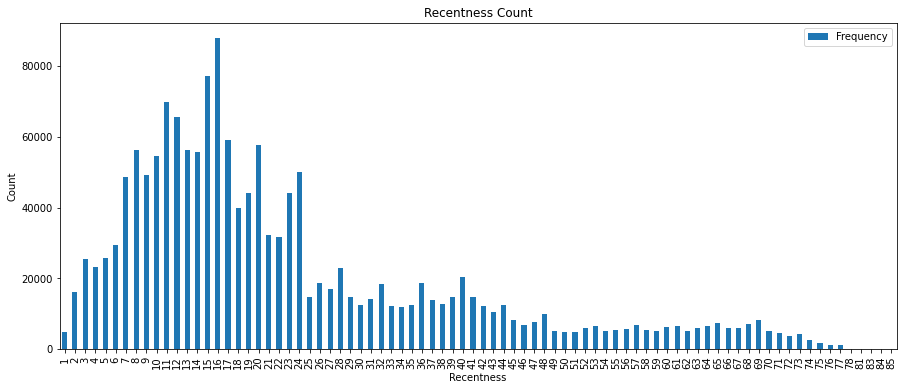

In [57]:
# review recentness
dfRecentness = dfMerged['recentness'].value_counts(sort=False).reset_index()
dfRecentness = dfRecentness.rename(columns={'index': 'Recentness', 'recentness': 'Frequency'})
dfRecentness['Recentness'] = dfRecentness['Recentness'] + 1 # start from 1 instead of 0
dfRecentness = dfRecentness.sort_values(by='Recentness')

dfRecentness.plot.bar(x='Recentness', y='Frequency', figsize=(15,6), title='Recentness Count', ylabel='Count')

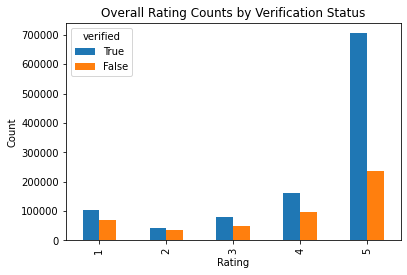

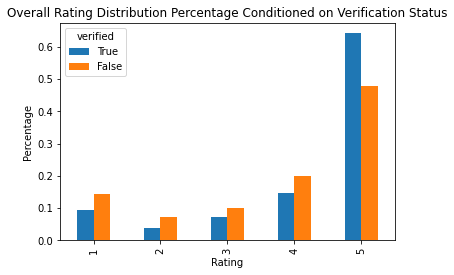

In [58]:
# rating distribution
# dfMerged['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution',
#                                                      xlabel='Rating', ylabel='Count')

dfRatingsByVerified = dfMerged.groupby('verified', sort=False).rating.value_counts(normalize=False).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Count', title='Overall Rating Counts by Verification Status')

dfRatingsByVerified = dfMerged.groupby('verified', sort=False).rating.value_counts(normalize=True).unstack(0)
dfRatingsByVerified.plot.bar(xlabel='Rating', ylabel='Percentage', 
                            title='Overall Rating Distribution Percentage Conditioned on Verification Status')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


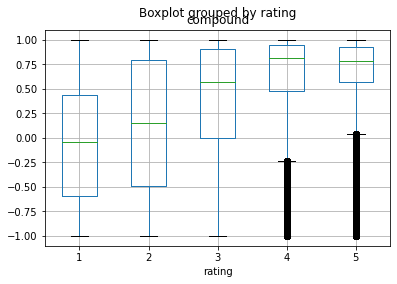

In [59]:
dfMerged.boxplot(column='compound', by='rating')

### Aggregate Reviews

In [107]:
dfMergedMinTime = dfMerged.groupby(by=['asin']).agg({'timeDiff': 'min', 'recentness': 'max'}).reset_index()

In [113]:
dfMerged = dfMerged.merge(dfMergedMinTime, how='left', on='asin', suffixes=('', '_y'))
dfMerged['recentnessReverse'] = dfMerged['recentness_y'] - dfMerged['recentness'] + 1
dfMerged['recentRating'] = dfMerged['recentnessReverse'] * dfMerged['rating']
dfMerged['recentCompound'] = dfMerged['recentnessReverse'] * dfMerged['compound']

In [173]:
# get mean rating, total numbers of reviews, and verified reviews per asin
dfAggr = dfMerged.groupby(['asin'], as_index=False).agg({'rating': 'mean', 'reviewerID': 'count', 'verified': [np.sum], 
                                                         'vote': 'mean', 'compound': 'mean',
                                                         'numStyles': 'sum', 
                                                         'numImages': 'min', 'numHighResImages': 'min',
                                                         'numDetails': 'min',
                                                         'price': 'min', 'rankVideoGames': 'min',
                                                         'recentRating': 'mean', 'recentCompound': 'mean'})
dfAggr.columns = ['_'.join(col).strip() for col in dfAggr.columns.values]

dfAggr = dfAggr.rename(columns={'asin_': 'asin', 'reviewerID_count': 'reviews_count',
                                'numImages_min': 'numImages', 'numHighResImages_min': 'numHighResImages',
                                'numDetails_min': 'numDetails', 'price_min': 'price', 
                                'rankVideoGames_min': 'rankVideoGames'})

In [174]:
dfAggr = dfAggr.astype({'vote_mean': np.float64, 'rankVideoGames': np.int64})

In [175]:
dfAggr.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40941 entries, 0 to 40940
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   asin                 40941 non-null  object 
 1   rating_mean          40941 non-null  float64
 2   reviews_count        40941 non-null  int64  
 3   verified_sum         40941 non-null  int64  
 4   vote_mean            40941 non-null  float64
 5   compound_mean        40941 non-null  float64
 6   numStyles_sum        40941 non-null  float64
 7   numImages            40941 non-null  uint8  
 8   numHighResImages     40941 non-null  uint8  
 9   numDetails           40941 non-null  uint8  
 10  price                6856 non-null   float64
 11  rankVideoGames       40941 non-null  int64  
 12  recentRating_mean    40941 non-null  float64
 13  recentCompound_mean  40941 non-null  float64
dtypes: float64(7), int64(3), object(1), uint8(3)
memory usage: 3.6+ MB


#### Verified Purchases

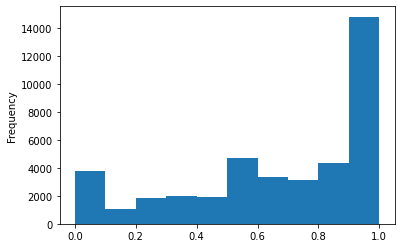

In [176]:
dfAggr['verified_percentage'] = dfAggr['verified_sum'] / dfAggr['reviews_count']
dfAggr['verified_percentage'].plot.hist(bins=10)

#### Mean Product Rating vs. Number of Reviews

In [87]:
# get mean rating and total counts per asin per verified
gcAsinVer = dfMerged.groupby(['asin', 'verified'], as_index=False).agg({'rating': 'mean', 'reviewerID': 'count'})
gcAsinVer = gcAsinVer.rename(columns={'rating': 'avgRating', 'reviewerID': 'numReviews'})
gcAsinVer = gcAsinVer.sort_values(by=['numReviews', 'asin', 'verified'], ascending=[False, True, True], ignore_index=True)

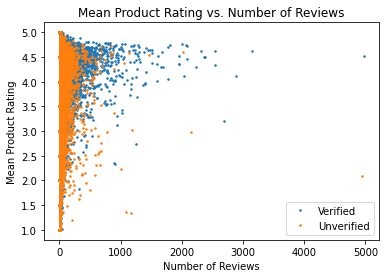

In [88]:
# plot scatterplot of ratings vs. number of reviews per product for verified and unverified reviews respectively
gcVerified = gcAsinVer.loc[gcAsinVer['verified'] == True]
gcUnverified = gcAsinVer.loc[gcAsinVer['verified'] == False]

plt.figure()
plt.plot(gcVerified['numReviews'], gcVerified['avgRating'], '.', markersize=3, label='Verified')
plt.plot(gcUnverified['numReviews'], gcUnverified['avgRating'], '.', markersize=3, label='Unverified')
plt.title('Mean Product Rating vs. Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Product Rating')
plt.legend()
plt.show()

#### Correlation

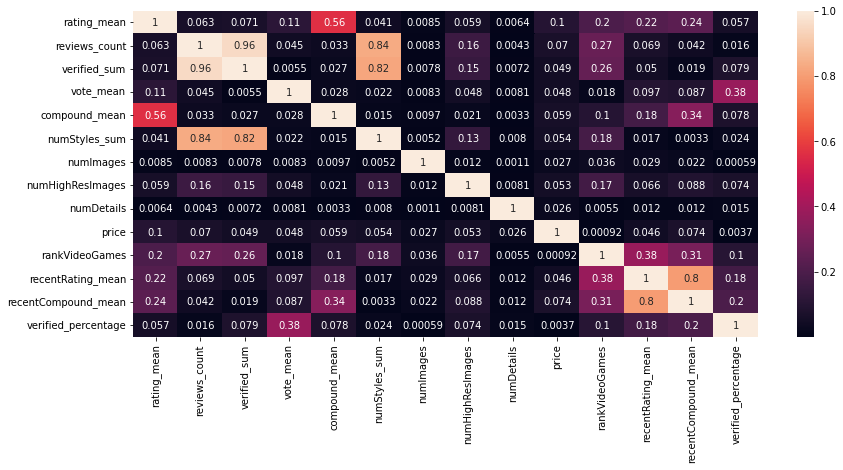

In [177]:
dfAggrCorr = dfAggr.corr()
dfAggrCorr = dfAggrCorr.abs()

plt.figure(figsize=(14, 6))
sns.heatmap(dfAggrCorr, annot=True)

#### Regression Model

In [119]:
import statsmodels.formula.api as sm

In [185]:
regResult = sm.ols(formula="rankVideoGames ~ rating_mean + reviews_count + verified_percentage + \
                            vote_mean + recentRating_mean + recentCompound_mean",
                   data=dfAggr).fit() # homogeneous regression

In [186]:
regResult.params

Intercept              128463.729414
rating_mean             -4985.955514
reviews_count             -83.842559
verified_percentage    -27668.708962
vote_mean               -1117.980795
recentRating_mean        -529.821479
recentCompound_mean      -195.461256
dtype: float64

In [187]:
regResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rankVideoGames   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     2206.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        04:12:52   Log-Likelihood:            -4.9522e+05
No. Observations:               40941   AIC:                         9.905e+05
Df Residuals:                   40934   BIC:                         9.905e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.285e+05   1025.994    125.209      0.000    1.26e+05     1.3e+05
rating_mean         -4985.9555    222.236    -22.435      0.000   -5421.543   -4550.368
reviews_count         -83.8426      1.573    -53.311      0.000     -86.925     -80.760
verified_percentage -2.767e+04    723.152    -38.261      0.000   -2.91e+04   -2.63e+04
vote_mean           -1117.9808    100.347    -11.141      0.000   -1314.663    -921.299
recentRating_mean    -529.8215     10.780    -49.151      0.000    -550.950    -508.693
recentCompound_mean  -195.4613     57.993     -3.370      0.001    -309.129     -81.794
==============================================================================
Omnibus:                     6799.709   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13297.455
Skew:                           1.023   Prob(JB):                         0.00
Kurtosis:                       4.900   Cond. No.                         752.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
heterogeneityReg = sm.ols(formula="rankVideoGames ~ rating_mean + reviews_count + verified_percentage + \
                            vote_mean + recentRating_mean + recentCompound_mean + \
                            numImages + numHighResImages + numDetails",
                   data=dfAggr).fit() # heterogeneity test

In [189]:
heterogeneityReg.params

Intercept              135990.543652
rating_mean             -5388.343483
reviews_count             -74.529485
verified_percentage    -25457.210531
vote_mean                -857.041681
recentRating_mean        -529.170429
recentCompound_mean      -285.912891
numImages                7520.944452
numHighResImages        -2579.023206
numDetails              -1540.278291
dtype: float64

In [190]:
heterogeneityReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rankVideoGames   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1675.
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        04:13:30   Log-Likelihood:            -4.9453e+05
No. Observations:               40941   AIC:                         9.891e+05
Df Residuals:                   40931   BIC:                         9.892e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.36e+05   1029.746    132.062      0.000    1.34e+05    1.38e+05
rating_mean         -5388.3435    218.840    -24.622      0.000   -5817.274   -4959.413
reviews_count         -74.5295      1.567    -47.561      0.000     -77.601     -71.458
verified_percentage -2.546e+04    713.704    -35.669      0.000   -2.69e+04   -2.41e+04
vote_mean            -857.0417     98.940     -8.662      0.000   -1050.967    -663.116
recentRating_mean    -529.1704     10.604    -49.905      0.000    -549.954    -508.387
recentCompound_mean  -285.9129     57.088     -5.008      0.000    -397.807    -174.019
numImages            7520.9445   1426.677      5.272      0.000    4724.626    1.03e+04
numHighResImages    -2579.0232     70.090    -36.796      0.000   -2716.402   -2441.644
numDetails          -1540.2783   1004.405     -1.534      0.125   -3508.934     428.378
==============================================================================
Omnibus:                     5969.131   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10385.494
Skew:                           0.962   Prob(JB):                         0.00
Kurtosis:                       4.544   Cond. No.                         968.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""